In [1]:
%matplotlib notebook

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import os
os.chdir('../')
import numpy as np
import matplotlib.pyplot as plt
from particle_tracker_one_d import ParticleTracker, ShortestPathFinder

# 1. Set the particle detection limit

<IPython.core.display.Javascript object>


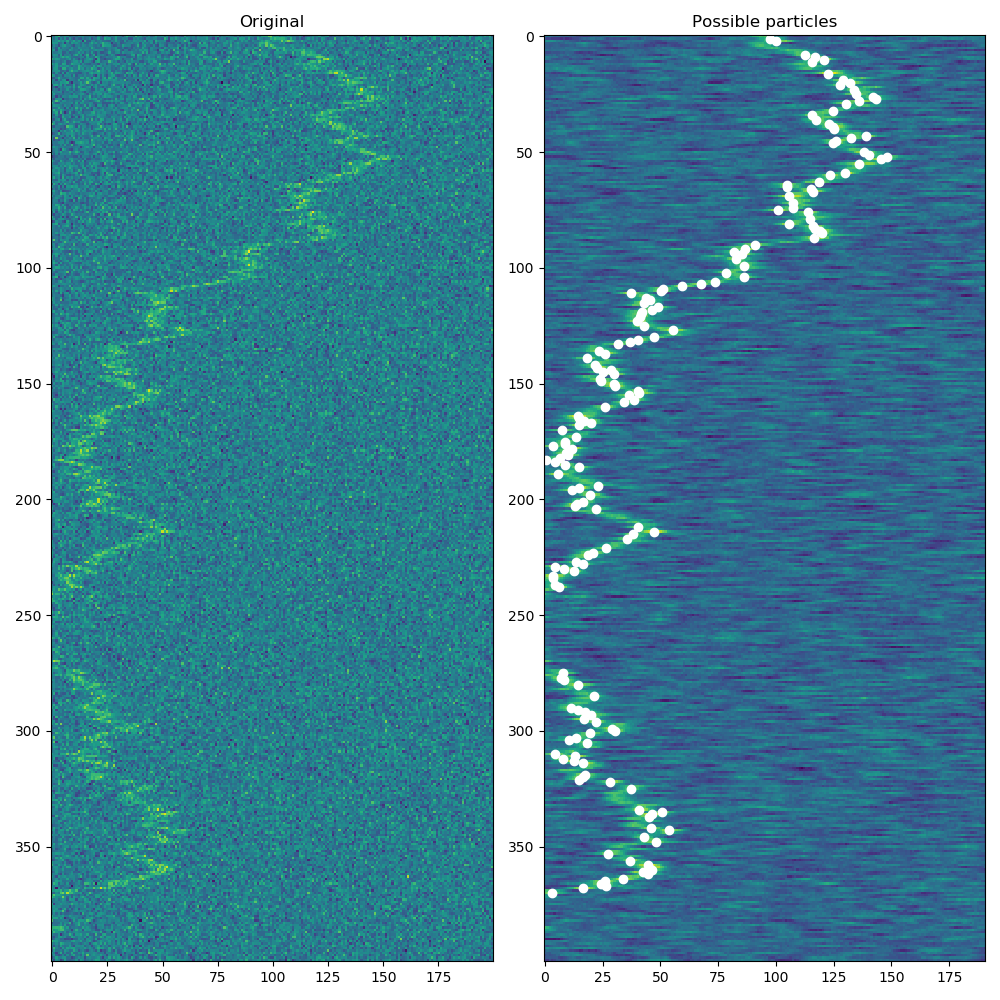

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Import the frames and the time data
frames = np.load('examples/frames.npy')
time = np.load('examples/time.npy')

# Normalise the intensity
frames_normalised = ParticleTracker.normalise_intensity(frames)

# Create a particle tracker instance
pt = ParticleTracker(frames=frames_normalised, time=time)

# Set initial properies of the particle tracker
pt.boxcar_width = 10
pt.integration_radius_of_intensity_peaks = 10
pt.particle_detection_threshold = 0.6

# Create a figure
fig, axes = plt.subplots(1,2,figsize=(10,10))

# Plot original frames
axes[0].imshow(frames, aspect='auto')

# Plot the kymograph
pt.plot_all_frames(ax=axes[1], aspect='auto')

# Plot all possible particle detections
pt.plot_all_particles(ax=axes[1], marker='o', color='white')

axes[0].set_title('Original')
axes[1].set_title('Possible particles')

fig.tight_layout()

# 2. Plot the moments and set the cost coefficients

<IPython.core.display.Javascript object>


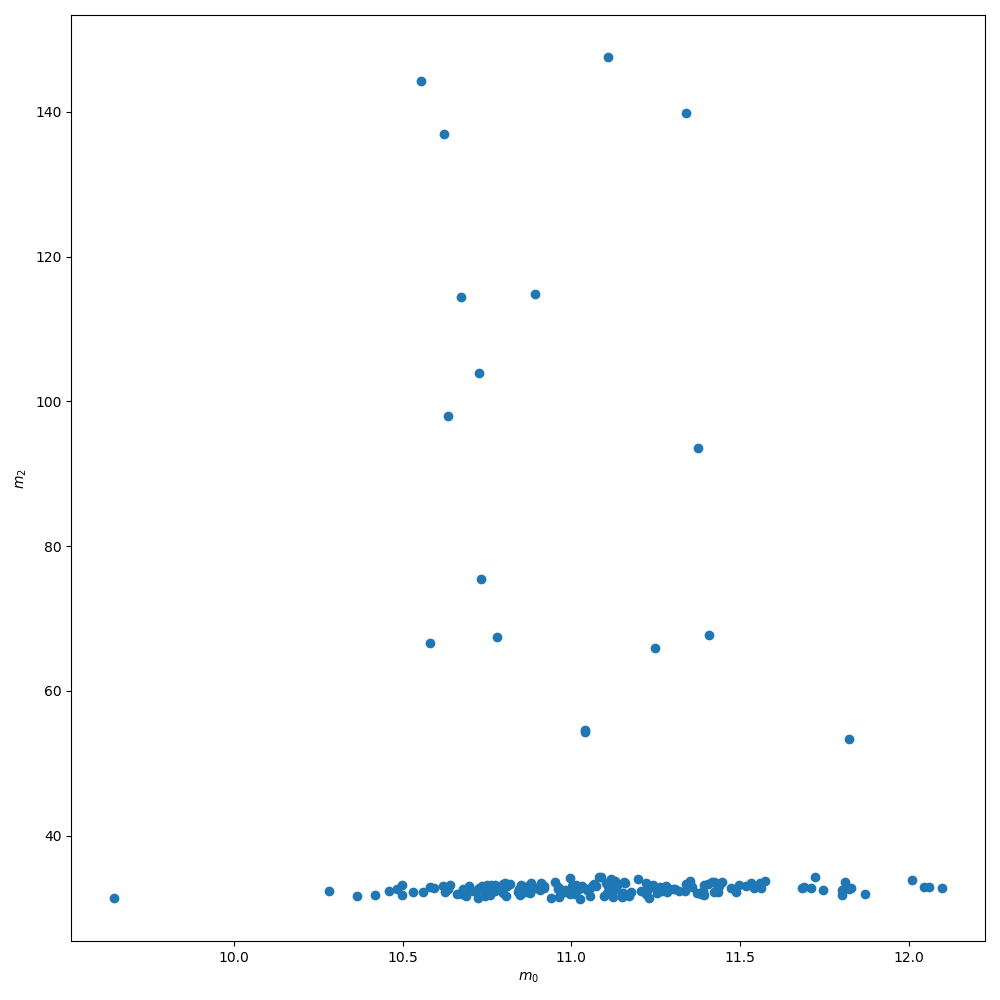

In [5]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

pt.plot_moments(ax=ax)

fig.tight_layout()

In [6]:
pt.change_cost_coefficients(1,0,0,5)

# 3. Set the final parameters

<IPython.core.display.Javascript object>


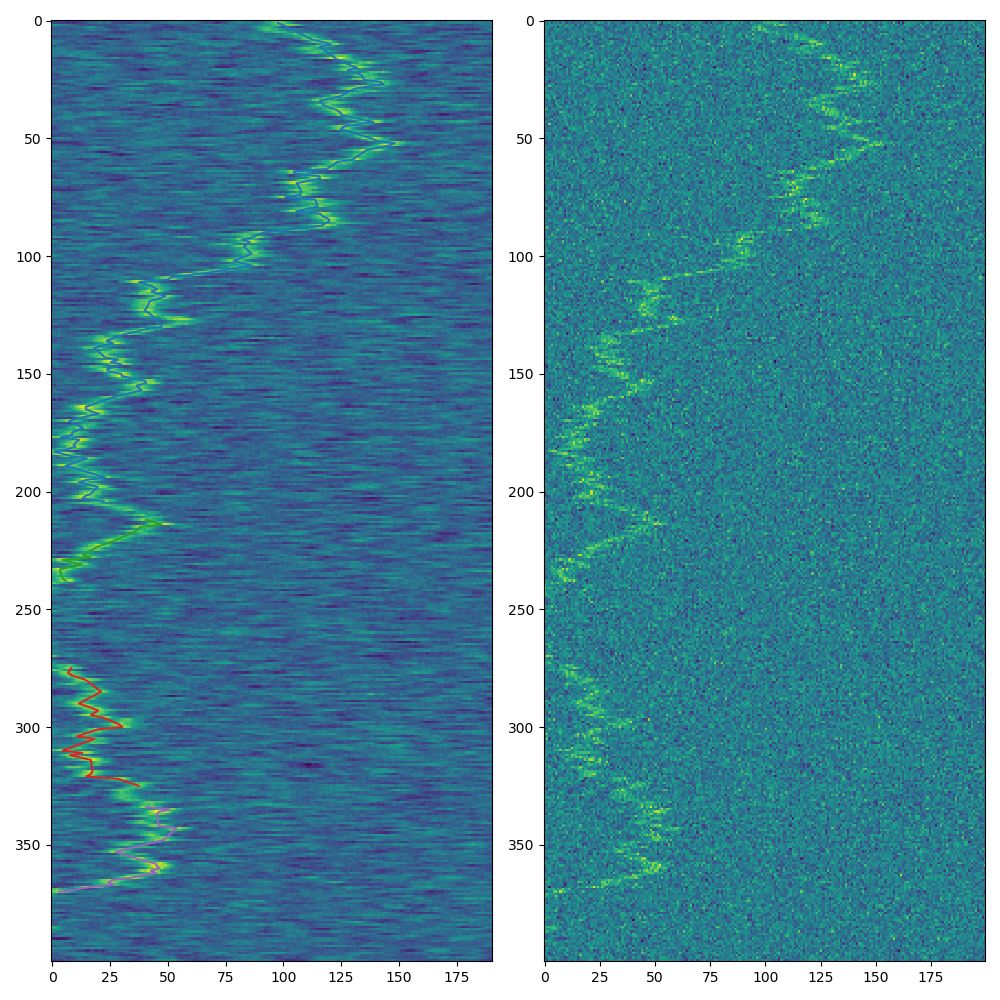

6


In [7]:
pt.maximum_number_of_frames_a_particle_can_disappear_and_still_be_linked_to_other_particles = 5
pt.maximum_distance_a_particle_can_travel_between_frames = 50

# Create a figure
fig, axes = plt.subplots(1,2,figsize=(10,10))

# Plot original frames
axes[1].imshow(frames, aspect='auto')

# Plot the kymograph
pt.plot_all_frames(ax=axes[0], aspect='auto')

# Plot all the trajectories
for t in pt.trajectories:
    t.plot_trajectory(x='position',y='frame_index',ax=axes[0])    
    
print(len(pt.trajectories))
    
fig.tight_layout()

# 4. Filter out too short trajectories

<IPython.core.display.Javascript object>


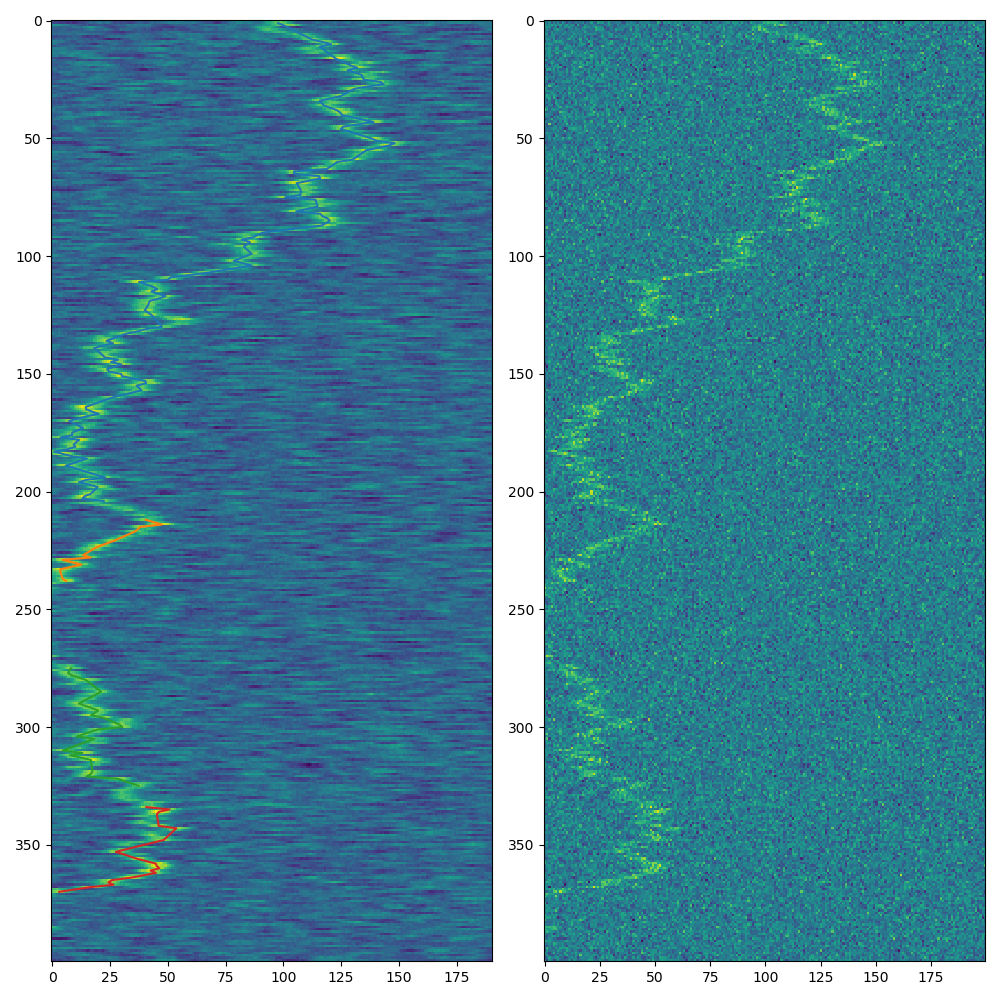

In [8]:
# Create a figure
fig, axes = plt.subplots(1,2,figsize=(10,10))

# Plot original frames
axes[1].imshow(frames, aspect='auto')

# Plot the kymograph
pt.plot_all_frames(ax=axes[0], aspect='auto')

# Plot all the trajectories
for t in pt.trajectories:
    if t.length > 10:
        t.plot_trajectory(x='position',y='frame_index',ax=axes[0])    
    
fig.tight_layout()

# 4. Refine trajectories with shortest path algorithm

In [9]:
type(t.particle_positions['frame_index'][0])

numpy.int16

In [10]:
spf = ShortestPathFinder(frames=frames_normalised, time=time)

spf.boxcar_width = pt.boxcar_width
spf.integration_radius_of_intensity_peaks = pt.integration_radius_of_intensity_peaks
spf.change_cost_coefficients(a=1,b=0,c=0)

final_trajectories = []

for t in pt.trajectories:
    if t.length > 10:
        spf.end_point = (0,0)
        spf.start_point = (0,0)
        spf.start_point = (int(t.particle_positions['frame_index'][0]),t.particle_positions['position'][0])
        spf.static_points = [(p['frame_index'], p['position'])for p in t.particle_positions[1:-1]]
        spf.end_point = (t.particle_positions['frame_index'][-1],t.particle_positions['position'][-1])
        final_trajectories.append(spf.trajectory)


In [11]:
t = pt.trajectories[-3]
spf.end_point = (0,0)
spf.start_point = (0,0)
spf.start_point = (int(t.particle_positions['frame_index'][0]),t.particle_positions['position'][0])
spf.static_points = [(p['frame_index'], p['position'])for p in t.particle_positions[1:-1]]
spf.end_point = (t.particle_positions['frame_index'][-1],t.particle_positions['position'][-1])
final_trajectories.append(spf.trajectory)

# 5. Final result

<IPython.core.display.Javascript object>


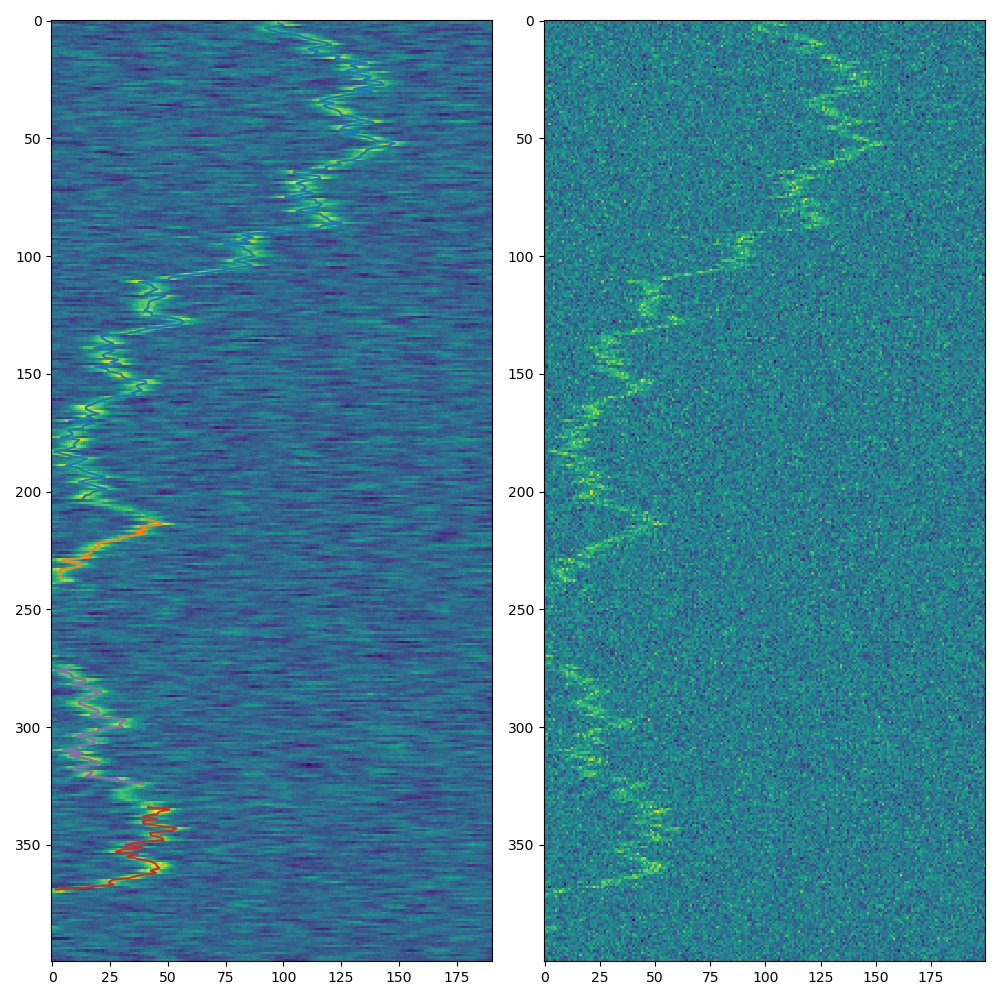

In [12]:
# Create a figure
fig, axes = plt.subplots(1,2,figsize=(10,10))

# Plot original frames
axes[1].imshow(frames, aspect='auto')

# Plot the kymograph
pt.plot_all_frames(ax=axes[0], aspect='auto')

# Plot all the trajectories
for t in final_trajectories:
    t.plot_trajectory(x='position',y='frame_index',ax=axes[0])    
    
fig.tight_layout()

# Find shortest path

In [18]:
# Import the frames and the time data
frames = np.load('examples/frames.npy')
time = np.load('examples/time.npy')

# Normalise the intensity
frames_normalised = ParticleTracker.normalise_intensity(frames)

# Create a shortest path finder instance
spf = ShortestPathFinder(frames=frames_normalised, time=time)

# Set the properies of the path finder
spf.boxcar_width = 5
spf.integration_radius_of_intensity_peaks = 20

# Set start point
spf.start_point = (0,90)

# Set end point
spf.end_point = (232,2)

<IPython.core.display.Javascript object>


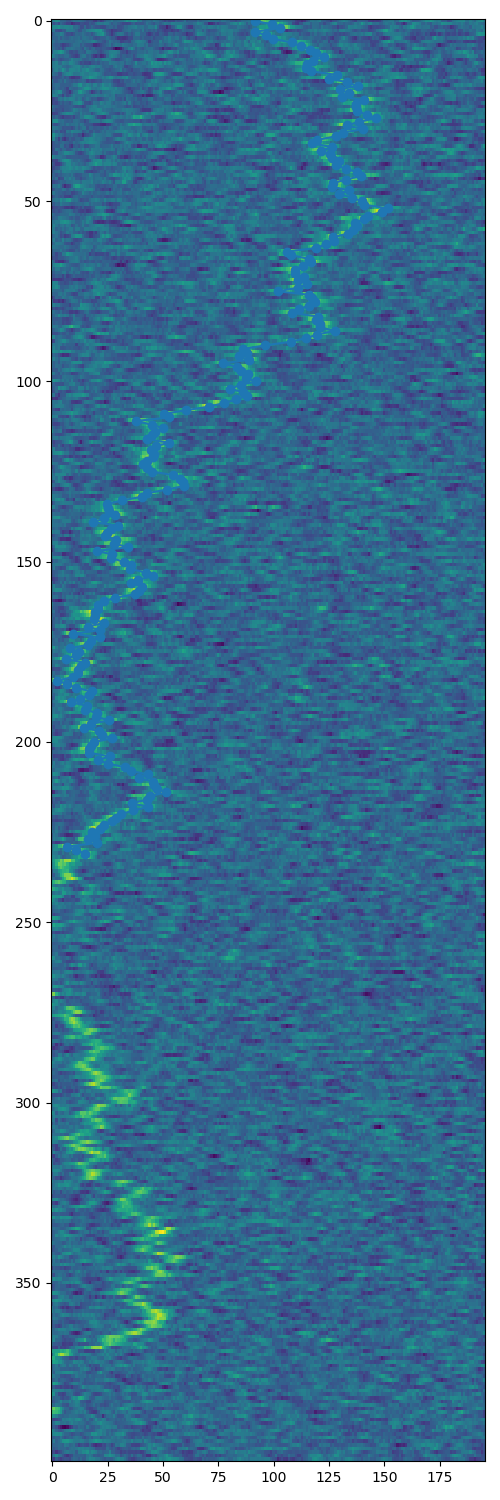

In [19]:
fig = plt.figure(figsize=(5,15))
ax = plt.axes()


spf.plot_all_frames(ax=ax, aspect='auto')
#ax.imshow(spf._intensity_of_interest,aspect='auto')

spf.trajectory.plot_trajectory(x='position', y='frame_index',ax=ax, marker='o')
fig.tight_layout()

# Simulation of trajectory

<IPython.core.display.Javascript object>


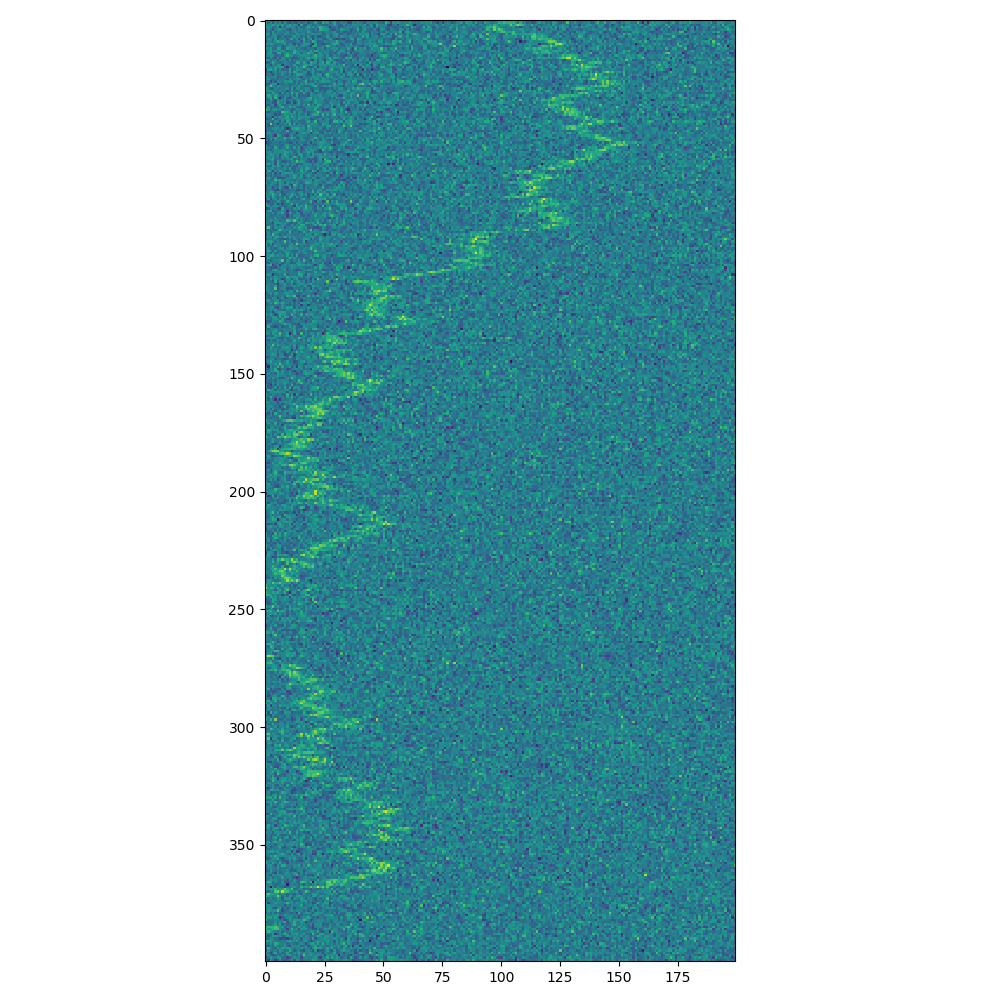

In [15]:
np.random.seed(12)
nr_of_frames = 400
pixels = 200
noise = np.random.poisson(10000, (nr_of_frames,pixels)).astype(np.int16)
time = np.linspace(0,100,nr_of_frames)
std_of_noise = np.std(noise)

# Simulate trajectory
trajectory = np.empty((nr_of_frames,),dtype=np.int16)
steps = np.random.normal(0,10,nr_of_frames-1)/2

# Start point
trajectory[0] = pixels/2
for index, step in enumerate(steps):
    trajectory[index+1] = trajectory[index] + step
    
# Intensity from particle
particle_intensity = np.zeros((nr_of_frames, pixels),dtype=np.int16)
x = np.linspace(0,pixels,pixels)
sigma = 3
for n in range(nr_of_frames):
    particle_intensity[n] = np.random.poisson(250*np.exp( - (x - trajectory[n])**2 / (2 * sigma**2)))


fig = plt.figure(figsize=(10,10))
ax = plt.axes()

ax.imshow(noise + particle_intensity)

frames = noise + particle_intensity
time = np.linspace(0,10,nr_of_frames)

fig.tight_layout()